In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math

from lenskit.datasets import ML100K, MovieLens
from lenskit.algorithms import Recommender, als

import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD, ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange


In [2]:
GENERATOR = np.random.default_rng(1234)

In [3]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [4]:
mf = ImplicitMF(num_users=1000, num_items=2000, num_latent_factors=20, num_items_per_iter=10)
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
mf.startup_and_train(20)
mf.run(timesteps=50, train_between_steps=True, reset_interactions=False)

100%|██████████| 20/20 [00:02<00:00,  9.74it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


In [5]:
mflfd = ImplicitMFLFD(num_users=1000, num_items=2000, num_latent_factors=20, num_items_per_iter=10)
mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
mflfd.startup_and_train(20)
mflfd.run(timesteps=50, train_between_steps=True, reset_interactions=False)

100%|██████████| 50/50 [02:22<00:00,  2.85s/it]


In [6]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mflfd_afsr= mflfd_metrics['afsr'].to_list()[21:]

mf_metrics = pd.DataFrame(mf.get_measurements())
mf_afsr= mf_metrics['afsr'].to_list()[21:]


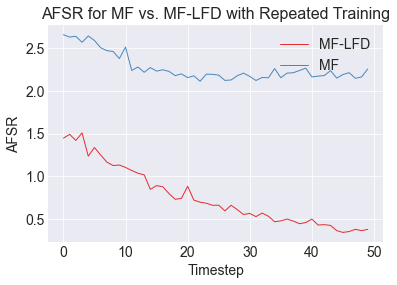

In [7]:
# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_afsr))), mflfd_afsr, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_afsr))), mf_afsr, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("AFSR for MF vs. MF-LFD with Repeated Training", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("AFSR")
plt.show()



In [9]:
mlsmall = MovieLens('../../t-recs-experiments/data/ml-latest-small')
ratings = mlsmall.ratings[['user', 'item']]

als = als.ImplicitMF(10, iterations=100)
als.fit(ratings)



In [11]:
als_item_features = pd.DataFrame(als.item_features_)
als_item_features.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.043608,0.038181,-0.264652,-0.010539,0.290712,-0.002614,-0.244641,-0.032198,0.278810,0.008049
1,-0.095129,-0.005981,-0.198978,-0.074919,0.235143,-0.007874,-0.141038,0.013464,0.271637,0.018454
2,0.007542,0.045007,-0.239515,-0.183052,0.066468,-0.062816,-0.045815,0.033261,0.300880,0.097381
3,0.053372,0.013553,-0.159093,-0.220602,0.032783,0.068257,0.066453,-0.040262,0.136115,0.056473
4,-0.073193,-0.017382,-0.129911,-0.219668,0.082466,0.086322,0.013729,-0.057080,0.320262,0.010226


In [20]:
def plot_hist_features(features_df, model_type, color='blue'):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Latent Factors for {}'.format(model_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        #hat = features_df[n_feature].tolist()
        features = features_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        #axs[r,c].plot(hat, actual, 'o', color=color);
        axs[r,c].hist(features, color=color)

    #for ax in axs.flat:
    #    ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


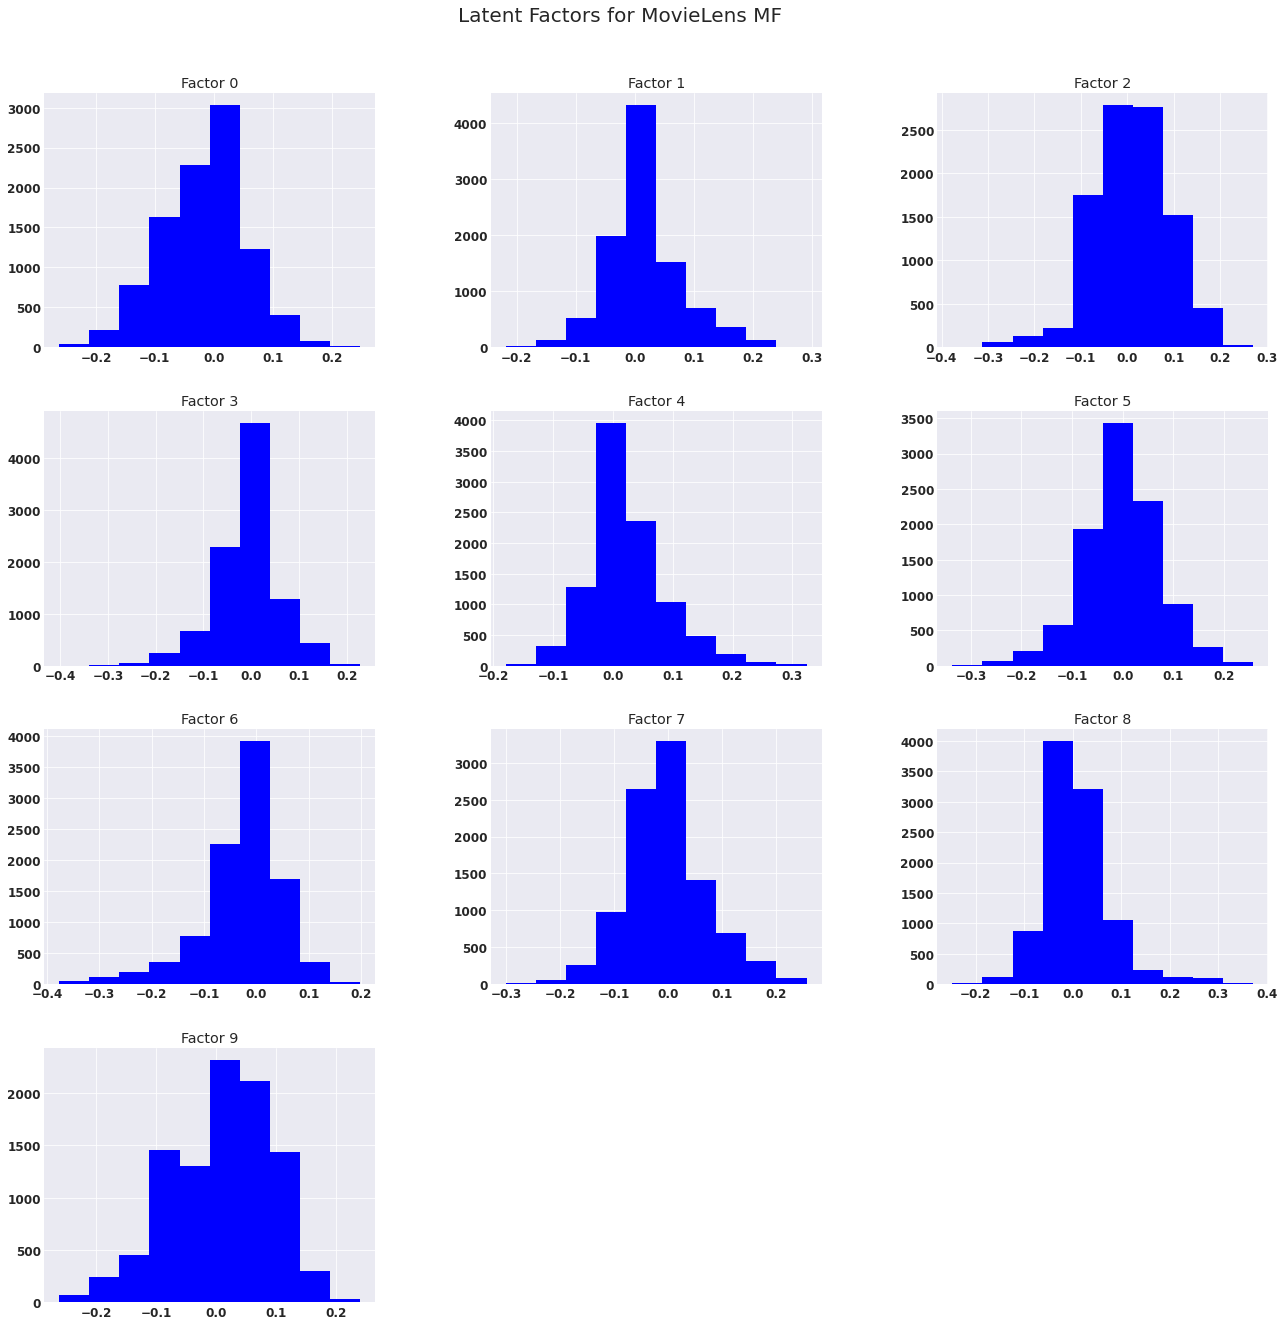

In [21]:
plot_hist_features(als_item_features, 'MovieLens MF')